In [1]:
## STANDARD PYTHON LIBS
import os
import re
import sys
import cv2
import PIL
import math
import time
import random
import scipy.misc
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## ADDING TO ROOT
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '../'))
sys.path.append(ROOT_DIR)

## CUSTOM LIBS
from src.model import log
import src.utils as utils
import src.model as modellib
from src.config import Config
import src.visualize as visualize

# GPU LIBS
import keras
import tensorflow as tf

print ('TF : ', tf.__version__, '  Keras : ', keras.__version__)

if utils.check_gpu(verbose=0):
    pass
else:
    sys.exit(1)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TF :  1.6.0   Keras :  2.1.4

 =========== nvidia-smi ========== 
Query for existing PIDs using GPU : nvidia-smi --query-compute-apps=pid --format=csv,noheader
 --->  ['4185']
Damn son! You gotta kill the PIDS - ['4185'] and then run nvidia-smi -r under root
 ---> Then come back and run this script again


Using TensorFlow backend.


SystemExit: 1

/home/play/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# CUSTOMIZATION

In [3]:
class MapillaryConfig(Config):
    NAME = "mapillary"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    NUM_CLASSES = 1 + 15  # background + 3 shapes
    # '0' '1' '17' '23' '24' '25' '26' '27' '28' '29' '30' '31' '32' '33' '8']
    
    IMAGE_MIN_DIM = 800 # in our case it does not matter
    IMAGE_MAX_DIM = 1024

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    TRAIN_ROIS_PER_IMAGE = 100
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5
    
config = MapillaryConfig()
# config.display()

In [61]:
class MapillaryDataset(utils.Dataset):
    
    def add_classes(self):
        self.dataset = 'mapillary'
        self.add_class(self.dataset, 0, "unlabelled")
        self.add_class(self.dataset, 1, "void-ego vehicle")
        self.add_class(self.dataset, 8, "flat-sidewalk")
        self.add_class(self.dataset, 17, "object-pole")
        self.add_class(self.dataset, 23, "sky-sky")
        self.add_class(self.dataset, 24, "human-person")
        self.add_class(self.dataset, 25, "human-rider")
        self.add_class(self.dataset, 26, "vehicle-car")
        self.add_class(self.dataset, 27, "vehicle-truck")
        self.add_class(self.dataset, 28, "vehicle-bus")
        self.add_class(self.dataset, 29, "vehicle-caravan")
        self.add_class(self.dataset, 30, "vehicle-trailer")
        self.add_class(self.dataset, 31, "vehicle-train")
        self.add_class(self.dataset, 32, "vehicle-motorcycle")
        self.add_class(self.dataset, 33, "vehicle-bicycle")
    
    def add_image_mapillary(self, image_id, image_folder_path, image_file_name):
        image_path = os.path.join(image_folder_path, image_file_name)
        self.add_image(self.dataset, image_id=image_id, path=None
                       , image_folder_path = image_folder_path, image_file_name = image_file_name)
    
    def load_image(self, image_id):
        image_folder_path = self.image_info[image_id]['image_folder_path']
        image_file_name   = self.image_info[image_id]['image_file_name']
        return cv2.imread(os.path.join(image_folder_path, image_file_name))
    
    def load_mask(self, image_id):
        image_folder_path = self.image_info[image_id]['image_folder_path']
        image_file_name   = self.image_info[image_id]['image_file_name']
        mask_file_name    = image_file_name.split('.png')[0] + '.npz'
        mask_file_path    = os.path.join(image_folder_path, mask_file_name)
        
        
        masks_res     = []
        class_ids_res = []
        masks_sparse = np.load(mask_file_path)
        for class_id in masks_sparse:
            for instance_id in masks_sparse[class_id].item():
                mask_class_instance = np.array(masks_sparse[class_id].item()[instance_id].todense())
                masks_res.append(mask_class_instance)
                class_ids_res.append(class_id)
                
        return np.array(masks_res), np.array(class_ids_res)

if __name__ == "__main__":
    trainData = MapillaryDataset()
    trainData.add_classes()
    trainData.add_image_mapillary(0, './raw/data', '_1AbvbARvB-5S0rAPN02Mg.png')
    img = trainData.load_image(0)

In [62]:
masks, class_ids = trainData.load_mask(0)

26


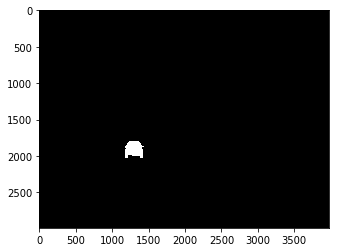

In [63]:
idx = 42

print
print (class_ids[idx])
plt.imshow(masks[idx], cmap='gray')

In [67]:
print (np.unique(masks[idx]))
# masks_idx  = 
_, contours, hierarchy = cv2.findContours(masks[idx], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_contours = cv2.drawContours(masks[idx], contours, -1, (0,255,0), 3)
print (np.unique(masks[idx]))
img_contours[img_contours == 1] = 255
plt.imshow(img_contours)

[  0 255]
[  0 255]
